<a href="https://colab.research.google.com/github/dattali18/Deep-Learning/blob/main/Assignment-2/deep_learning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning

## Assignment 2

Testing the effect of the hidden leayer in a fully connected nerual network.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Import `typing` to make the code more readable

In [2]:
from typing import Callable

Createing a `Activation` class to make changing activation function in our neural network easier

In [3]:
class Activation:
    def __init__(self, activation: Callable, activation_der: Callable):
        self.activation = activation
        self.activation_der = activation_der

    def __call__(self, z: np.ndarray) -> np.ndarray:
        return self.activation(z)

    def der(self, z: np.ndarray) -> np.ndarray:
        return self.activation_der(z)

Creating a meta class `Functions` to store and create (in the manner of the `Builder Pattern`) activation function

In [4]:
class Functions:
    def __init__(self, activation: str):
        self.activation_ = activation

    def activation(self) -> Activation:
        if self.activation_ == "tanh":
            return Activation(self.tanh, self.tanh_der)
        elif self.activation_ == "sigmoid":
            return Activation(self.sigmoid, self.sigmoid_der)
        else:
            return Activation(self.relu, self.relu_der)

    def tanh(self, z: np.ndarray) -> np.ndarray:
        return np.tanh(z)

    def tanh_der(self, z: np.ndarray) -> np.ndarray:
        X = np.tanh(z)
        return 1 - X**2

    def sigmoid(self, z: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-z))

    def sigmoid_der(self, z: np.ndarray) -> np.ndarray:
        A = self.sigmoid(z)
        return A * (1 - A)

    def relu(self, z: np.ndarray) -> np.ndarray:
        return np.maximum(0, z)

    def relu_der(self, z: np.ndarray) -> np.ndarray:
        return np.where(z > 0, 1, 0)

Defining a `NN` class to make cerating, training and testing the neural network easier and repetable

In [6]:
class NN:
    def __init__(
        self, input: int, output: int, hidden: int, learning_rate: float = 0.1
    ):
        self.input = input
        self.output = output
        self.hidden = hidden
        self.learning_rate = learning_rate
        self.parameters = self.initialize_parameters()
        # default activation function is tanh
        self.activation = Functions("tanh").activation()

    def initialize_parameters(self) -> dict[str, np.ndarray]:
        return {
            "W1": np.random.randn(self.hidden, self.input) * 0.01,
            "b1": np.zeros([self.hidden, 1]),
            "W2": np.random.randn(self.output, self.hidden) * 0.01,
            "b2": np.zeros([self.output, 1]),
        }

    def forward_propagation(
        self, X: np.ndarray
    ) -> tuple[np.ndarray, dict[str, np.ndarray]]:
        # Hidden Layer
        Z1 = self.parameters["W1"].dot(X.T) + self.parameters["b1"]
        A1 = self.activation(Z1)
        # Output Layer
        Z2 = self.parameters["W2"].dot(A1) + self.parameters["b2"]
        A2 = self.sigmoid(Z2)
        cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
        return A2, cache

    def backward_propagation(self, cache: dict, X: np.ndarray, Y: np.ndarray) -> dict:
        m = X.shape[1]
        # Output Layer
        dZ2 = cache["A2"] - Y
        dW2 = (1 / m) * dZ2.dot(cache["A1"].T)
        db2 = (1 / m) * np.sum(dZ2)

        # Hidden Layer
        dA1 = np.dot(self.parameters["W2"].T, dZ2)
        dZ1 = dA1 * self.activation.der(cache["Z1"])
        dW1 = (1 / m) * np.dot(dZ1, X)
        db1 = (1 / m) * np.sum(dZ1)

        return {"dW1": dW1, "dW2": dW2, "db1": db1, "db2": db2}

    def update_parameters(self, grads: dict[str, np.ndarray]) -> None:
        self.parameters["W1"] -= self.learning_rate * grads["dW1"]
        self.parameters["b1"] -= self.learning_rate * grads["db1"]
        self.parameters["W2"] -= self.learning_rate * grads["dW2"]
        self.parameters["b2"] -= self.learning_rate * grads["db2"]

    def train(self, X: np.ndarray, Y: np.ndarray, epochs: int) -> None:
        for _ in range(epochs):
            A, cache = self.forward_propagation(X)
            cost = self.LogLoss(A, Y) # TODO: add to cost list and plot
            grads = self.backward_propagation(cache, X, Y)
            self.update_parameters(grads)
            # print(f"Epoch {i+1}/{epochs} - cost: {cost}")

    def predict(self, X: np.ndarray) -> np.ndarray:
        A, _ = self.forward_propagation(X)
        return np.round(A)

    def evaluate(self, X: np.ndarray, Y: np.ndarray) -> float:
        A, _ = self.forward_propagation(X)
        A = np.round(A)
        return float(np.mean(A == Y))

    def LogLoss(self, A: np.ndarray, Y: np.ndarray) -> float:
        return float(np.mean(-(Y * np.log(A) + (1 - Y) * np.log(1 - (A)))))

    def sigmoid(self, z: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-z))

Adding a manipulation function to manipulate the df into the different tables needed in the assginment

In [8]:
def manipulation(df: pd.DataFrame) -> list[tuple[str, pd.DataFrame, pd.DataFrame]]:
    # data frame manipulation

    # the first line in the df is the logistic regression
    logistic = df.iloc[0]

    activations = ["tanh", "sigmoid", "relu"]
    dfs = []

    # add the logistic regression to the df for each pivot for each activation
    for activation in activations:
        df_activation = df[df["activation"] == activation]

        # Create a pivot table for test_accuracy
        df_test = df_activation.pivot(
            index="hidden_size", columns="epochs", values="test_accuracy"
        )
        df_test.loc[0] = logistic["test_accuracy"]

        # Create a pivot table for train_accuracy
        df_train = df_activation.pivot(
            index="hidden_size", columns="epochs", values="train_accuracy"
        )
        df_train.loc[0] = logistic["train_accuracy"]

        dfs.append((activation, df_train, df_test))

    return dfs

defining a ploting class that will take the different tuple in the dfs var and plot them in a nice way

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_results(dfs: list[tuple[str, pd.DataFrame, pd.DataFrame]]) -> None:
    # the plot need to be a line plot with the x-axis being the number of epochs
    # plotting the results
    for activation, df_train, df_test in dfs:
        # a bar plot that has both the train and test accuracy
        # and the x-axis is the number of epochs
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        sns.heatmap(df_train, annot=True, fmt=".2f", cmap="coolwarm")
        plt.title(f"Train Accuracy - {activation}")
        plt.xlabel("Epochs")
        plt.ylabel("Hidden Size")

        plt.subplot(1, 2, 2)
        sns.heatmap(df_test, annot=True, fmt=".2f", cmap="coolwarm")
        plt.title(f"Test Accuracy - {activation}")
        plt.xlabel("Epochs")
        plt.ylabel("Hidden Size")

        plt.tight_layout()
        plt.show()

Adding a print function that will display the result nicly

In [23]:
def print_results(dfs: list[tuple[str, pd.DataFrame, pd.DataFrame]]) -> None:
    for activation, df_train, df_test in dfs:
        print(f"Activation: {activation}")
        print("Train Accuracy")
        print(df_train)
        print("Test Accuracy")
        print(df_test)

Defining the main function where we loop over the different activation function and the different hidden layer size and the different ephocs

In [29]:
import os

def main() -> None:
    # loading the data
    # if the result.csv file is in the same folder as the main.py file load it
    if "results.csv" in os.listdir():
        df = pd.read_csv("results.csv")
        dfs = manipulation(df)
        plot_results(dfs)
        print_results(dfs)
        return

    url = "https://github.com/rosenfa/nn/blob/master/pima-indians-diabetes.csv?raw=true"

    df = pd.read_csv(url, header=0)
    features = df.drop(["Outcome"], axis=1)
    features = (features - features.mean()) / features.std()
    X = np.array(features)
    Y = np.array(df["Outcome"])

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)
    X_train, X_test = X_train.T, X_test.T

    # the assignment is to test different hidden layers size and activation functions
    # we need to test the following:
    # train vs test accuracy
    # hidden size = [1, 2, 3, 4, 5, 6]
    # activation functions = [tanh, sigmoid]
    # number of epochs = [100, 200, 300]
    # then we store every result into a data frame and this data frame into a file
    # the data frame should have the following columns:
    # hidden_size, activation, epochs, train_accuracy, test_accuracy

    hidden_size = [1, 2, 3, 4, 5, 6]
    activation_functions = ["tanh", "sigmoid", "relu"]
    results = []

    # add logistic for comparison
    logistic = LogisticRegression()
    logistic.fit(X_train.T, Y_train)
    logistic_train_accuracy = logistic.score(X_train.T, Y_train)
    logistic_test_accuracy = logistic.score(X_test.T, Y_test)
    results.append(
        ["NA", "logistic", 0, logistic_train_accuracy, logistic_test_accuracy]
    )

    for activation in activation_functions:
        for hidden in hidden_size:
            for epoch in range(500, 2500, 500):
                # setting up the neural network
                nn = NN(X_train.shape[0], 1, hidden)
                functions = Functions(activation)
                nn.activation = functions.activation()

                # training the neural network
                nn.train(X_train.T, Y_train, epoch)
                train_accuracy = nn.evaluate(X_train.T, Y_train)
                test_accuracy = nn.evaluate(X_test.T, Y_test)
                # storing the results
                results.append(
                    [hidden, activation, epoch, train_accuracy, test_accuracy]
                )
            print(f"Hidden size: {hidden}, Activation: {activation} - Done")

    # creating the data frame
    df = pd.DataFrame(
        results,
        columns=[
            "hidden_size",
            "activation",
            "epochs",
            "train_accuracy",
            "test_accuracy",
        ],
    )
    # save the file to the /Assignment-2 folder where the main.py is located
    df.to_csv("results.csv", index=False)

    dfs = manipulation(df)

    # plotting the results
    plot_results(dfs)

    # print the results
    print_results(dfs)

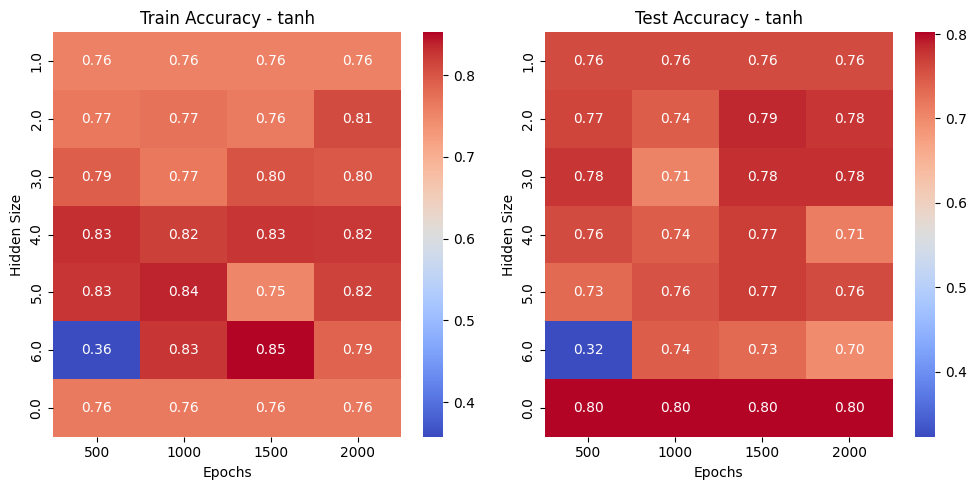

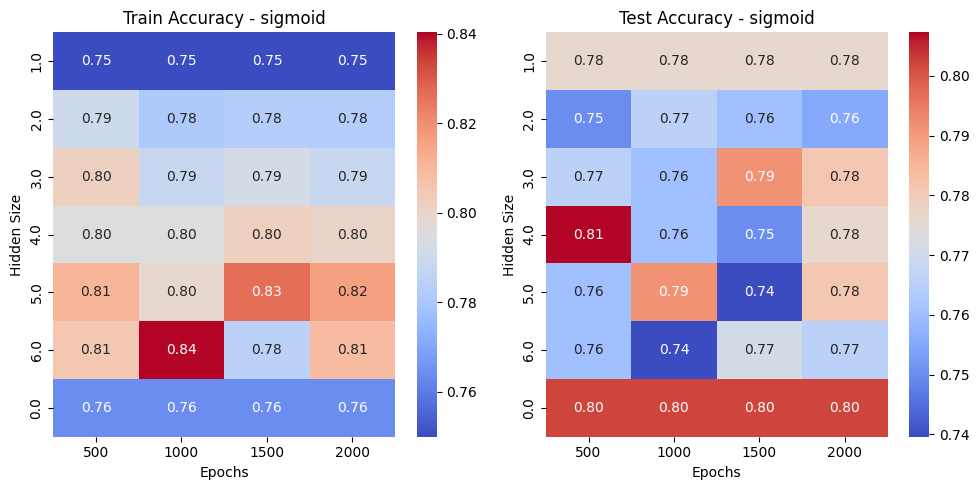

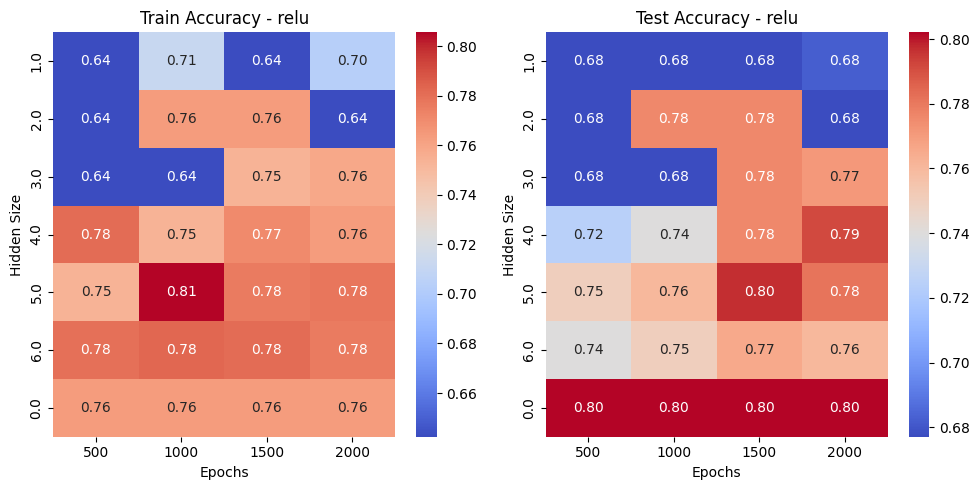

Activation: tanh
Train Accuracy
epochs           500       1000      1500      2000
hidden_size                                        
1.0          0.756944  0.756944  0.756944  0.756944
2.0          0.765625  0.772569  0.762153  0.809028
3.0          0.791667  0.765625  0.802083  0.796875
4.0          0.829861  0.817708  0.826389  0.824653
5.0          0.826389  0.838542  0.751736  0.815972
6.0          0.357639  0.826389  0.852431  0.788194
0.0          0.763889  0.763889  0.763889  0.763889
Test Accuracy
epochs           500       1000      1500      2000
hidden_size                                        
1.0          0.760417  0.760417  0.760417  0.760417
2.0          0.765625  0.744792  0.786458  0.776042
3.0          0.776042  0.708333  0.781250  0.781250
4.0          0.760417  0.744792  0.770833  0.713542
5.0          0.734375  0.755208  0.770833  0.760417
6.0          0.322917  0.744792  0.734375  0.697917
0.0          0.802083  0.802083  0.802083  0.802083
Activation: sigmoi

In [30]:
main()